In [1]:
import gym
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random

from keras.models import Sequential
from keras.layers import Dense, Activation

Using TensorFlow backend.


In [2]:
from snake import SnakeEnv

env = SnakeEnv(size=5)

for episode in range(1):
    observation = env.reset()
    while True:
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            break

In [3]:
"""
Environment Parameters
"""
observation_space = 5*5
action_space = 5
seed = 10

"""
Agent Parameters
"""
episodes = 5000
epsilon_init = 1.0
epsilon_decay = 0.002
epsilon_min = 0.1
gamma = 0.99

"""
Model Parameters
"""
batch_size = 128
hidden_dims = 32
activation = 'relu'
optim = 'rmsprop'
loss_func = 'mse'

In [4]:
random.seed(seed)
np.random.seed(seed)

In [5]:
class DQN:
    def __init__(self):
        self.model = self.build_dqn()
        self.latest = None
        # experience replay
        self.buffer = []
        
    def build_dqn(self):
        dqn = Sequential()
        dqn.add(Dense(hidden_dims, input_shape=(observation_space,)))
        dqn.add(Activation(activation))
        
        dqn.add(Dense(hidden_dims))
        dqn.add(Activation(activation))
        
        dqn.add(Dense(action_space))
        dqn.compile(optimizer=optim, loss=loss_func)
        return dqn
    
    def train(self):
        batch = random.sample(self.buffer, batch_size)
        inputs = []
        labels = []
        for sample in batch:
            s, a, r, s_p, d = sample
            
            s = np.reshape(s.flatten(), (1, observation_space))
            s_p = np.reshape(s_p.flatten(), (1, observation_space))
            
            inputs.append(s)
            label = self.predict(s)
            label[0][a] = r
            if not d:
                label[0][a] += gamma*np.max(self.target_predict(s_p))
            labels.append(label)
        inputs = np.squeeze(np.array(inputs), axis=1)
        labels = np.squeeze(np.array(labels), axis=1)
        self.model.fit(inputs, labels, verbose=0)
        
    def predict(self, s):
        return self.model.predict(s)
    
    def target_predict(self, s):
        return self.model.predict(s)
    
    def record_state_tuple(self, state_tuple):
        #self.latest = state_tuple
        self.buffer.append(state_tuple)

In [6]:
simple_dqn = DQN()

In [7]:
def run_episode(env, model, epsilon=0.0,
                training=False, render=False):
    total_reward = 0
    done = False
    state = np.expand_dims(env.reset(), 0)
    state = np.reshape(state.flatten(), (1, observation_space))

    frames = []
    while not done:
        if render:
            pass
#             env.render()
        if training and random.random() < epsilon:
            action = env.action_space.sample()
        else:
            q_values = model.predict(state)
            action = np.argmax(q_values)
        next_state, reward, done, _ = env.step(action)
        next_state = np.expand_dims(next_state, 0)
        
        next_state = np.reshape(state.flatten(), (1, observation_space))
        
        total_reward += reward
        if training:
            exp_tuple = (state, action, reward, next_state, done)
            model.record_state_tuple(exp_tuple)
        state = next_state
    if training:
        model.train()
    epsilon -= epsilon_decay
    epsilon = max(epsilon, epsilon_min)
    return total_reward, epsilon

In [8]:
def warmup_buffer(env, model):
    for _ in range(50):
        done = False
        state = np.expand_dims(env.reset(), 0)
        while not done:
            action = env.action_space.sample()
            next_state, reward, done, _ = env.step(action)
            next_state = np.expand_dims(next_state, 0)
            exp_tuple = (state, action, reward, next_state, done)
            model.record_state_tuple(exp_tuple)
            state = next_state

In [9]:
"""
Target Network Parameters
"""
target_decay = 0.99

In [10]:
class TargetDQN(DQN):
    def __init__(self):
        self.target = self.build_dqn()
        super(TargetDQN, self).__init__()
        
    def train(self):
        super(TargetDQN, self).train()
        self.update_target()
        
    # Exponentially weighted average
    def update_target(self):
        model_weights = self.model.get_weights()
        target_weights = self.target.get_weights()
        for i in range(len(target_weights)):
            target_weights[i] = target_decay * target_weights[i] + \
                                (1 - target_decay) * model_weights[i]
        self.target.set_weights(target_weights)
    
    def target_predict(self, s):
        return self.target.predict(s)

In [11]:
better_dqn = TargetDQN()

In [12]:
warmup_buffer(env, better_dqn)
eps = epsilon_init
sum_reward = 0

avgs = []

for episode in range(1, episodes+1):
    r, eps = run_episode(env, better_dqn, epsilon=eps, training=True)
    sum_reward += r
    if episode % 100 == 0:
        avg = sum_reward / 100
        sum_reward = 0
        start = episode - 99
        avgs.append(avg)
        print("Average total reward for episode " + \
              f"{start} through {episode}: {avg}")

Average total reward for episode 1 through 100: 1.4
Average total reward for episode 101 through 200: 1.8
Average total reward for episode 201 through 300: 2.1
Average total reward for episode 301 through 400: 2.1
Average total reward for episode 401 through 500: 3.0
Average total reward for episode 501 through 600: 1.9
Average total reward for episode 601 through 700: 3.1
Average total reward for episode 701 through 800: 2.9
Average total reward for episode 801 through 900: 2.7
Average total reward for episode 901 through 1000: 2.5
Average total reward for episode 1001 through 1100: 2.3
Average total reward for episode 1101 through 1200: 2.9
Average total reward for episode 1201 through 1300: 3.5
Average total reward for episode 1301 through 1400: 1.8
Average total reward for episode 1401 through 1500: 2.8
Average total reward for episode 1501 through 1600: 2.3
Average total reward for episode 1601 through 1700: 2.2
Average total reward for episode 1701 through 1800: 3.3
Average total

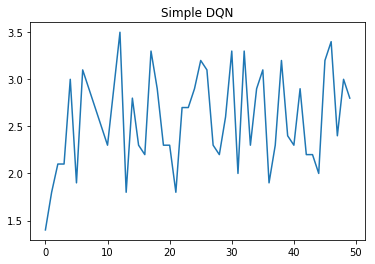

In [13]:
plt.plot(avgs)
plt.title('Simple DQN')
plt.show()